In [1]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#keep track of things:
logger = phoebe.logger(clevel='INFO', flevel='DEBUG', filename='tutorial.log')
print( logger)

In [3]:
#Making parameters:
param = phoebe.parameters.StringParameter(qualifier='myparameter', 
                                          description='mydescription',
                                          value='myvalue')

print(param)
print("")
print(param.tags)
print(" ")
print( param['qualifier'], param.qualifier)
print(" ")
print(param.attributes)
print(" ")
print( param.get_value(), param['value'], param.value)
print(" ")

#you can also change parameters:
param.set_value('newvalue')
print param.get_value()

Parameter: myparameter
                       Qualifier: myparameter
                     Description: mydescription
                           Value: myvalue


OrderedDict([('time', None), ('qualifier', 'myparameter'), ('feature', None), ('component', None), ('dataset', None), ('constraint', None), ('compute', None), ('model', None), ('kind', None), ('context', None)])
 
('myparameter', 'myparameter')
 
['description', 'value', 'visible_if', 'copy_for']
 
('myvalue', 'myvalue', 'myvalue')
 
newvalue


In [4]:
#Building a system

b = phoebe.Bundle.default_binary()
print (b.hierarchy)
print(" ")

#for a contact binary, use:
b = phoebe.default_binary(contact_binary=True)
print b.hierarchy


    orbit:binary 
    
        star:primary 
        star:secondary
    

 

    orbit:binary 
    
        star:primary 
        star:secondary 
        envelope:contact_envelope
    



In [5]:
#to add components manually, you can use "add_component"
b = phoebe.Bundle()
b.add_component(phoebe.component.star, component='primary')
b.add_component('star', component='secondary')


#can also use "add_star" and "add_orbit"
b.add_star('extrastarforfun', teff=6000)
b.add_orbit('binary')

<ParameterSet: 17 parameters | qualifiers: dpdt, mean_anom, asini, ecc, dperdt, period, long_an, q, t0_supconj, per0, sma, esinw, t0_ref, freq, incl, ecosw, t0_perpass>

In [6]:
#now to set the hierarchey of this system:
b.set_hierarchy(phoebe.hierarchy.binaryorbit, b['binary'], b['primary'], b['secondary'])

#you can also do this using string parameters:
b.set_hierarchy('orbit:binary(star:primary, star:secondary)')

In [7]:
# saving files you can use "save" command which produces JSON-formatted files

b['incl@orbit'] = 56.789

print b.save('test.phoebe')

#you can view 1st 30 lines of saved file like so:
!head -n 30 test.phoebe

test.phoebe
[
{
"Class": "FloatParameter",
"context": "system",
"copy_for": false,
"default_unit": "d",
"description": "Time at which all values are provided",
"limits": [
null,
null
],
"qualifier": "t0",
"value": 0.0
},
{
"Class": "FloatParameter",
"context": "system",
"copy_for": false,
"default_unit": "deg",
"description": "Right ascension",
"limits": [
null,
null
],
"qualifier": "ra",
"value": 0.0
},
{
"Class": "FloatParameter",
"context": "system",


In [8]:
#loading exisiting bundles:
b2 = phoebe.Bundle.open('test.phoebe')
print b2.get_value('incl@orbit')

56.789


In [9]:
#applying constraints

# what are the current constraints on our system?
b.filter(context='constraint')
print(" ")

#let's check a specific constraint: primary star's mass
print b['constraint']['primary']['mass']
print(" ")
# or
print b.get_value('mass@primary@component')

 
Constrains (qualifier): mass
Expression in solar units (value): (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * (1.000000 + {q@binary@component})) * 2942.206217504418873431859537959099)
Current Result (result): 0.998813135806 solMass
 
0.998813135806


In [10]:
# there are a number of other built-in constraints:

# a*sin(i)
print b['asini@constraint']
print(" ")

# e*sin(w), e*cos(w)
print b['esinw@constraint']
print(" ")
print b['ecosw@constraint']

# t0
print(" ")
print b['t0_perpass@constraint']

#frequency
print(" ")
print b['freq@constraint']

# mass
print(" ")
b['mass@constraint']

# semi-major axis
print(" ")
print b['sma@constraint']
print b['sma@primary@constraint']

# maxium equivalent radius (for a detached system)
print(" ")
print b['requiv_max@constraint']
print b['requiv_max@primary@constraint']

print(" ")
# rotation period 
print b['period@constraint']
print b['period@primary@constraint']

print(" ")
# pitch constrains the relation between the orbital and rotational inclination 
print b['incl@primary@constraint']
print(" ")

# yaw constrains the relation between the orbital and rotational long_an
b['long_an@primary@constraint']

Constrains (qualifier): asini
Expression in solar units (value): {sma@binary@component} * (sin({incl@binary@component}))
Current Result (result): 4.43429361927 solRad
 
Constrains (qualifier): esinw
Expression in solar units (value): {ecc@binary@component} * (sin({per0@binary@component}))
Current Result (result): 0.0
 
Constrains (qualifier): ecosw
Expression in solar units (value): {ecc@binary@component} * (cos({per0@binary@component}))
Current Result (result): 0.0
 
Constrains (qualifier): t0_perpass
Expression in solar units (value): t0_supconj_to_perpass({t0_supconj@binary@component}, {period@binary@component}, {ecc@binary@component}, {per0@binary@component})
Current Result (result): -0.25 d
 
ParameterSet: 4 parameters
         freq@primary@constraint: 6.283185 / {period@primary@component}
       freq@secondary@constraint: 6.283185 / {period@secondary@component}
  freq@extrastarforfun@constr...: 6.283185 / {period@extrastarforfun@component}
          freq@binary@constraint: 6.2831

<ConstraintParameter: {long_an@primary@component} = {long_an@binary@component} + {yaw@primary@component} (solar units) => 0.0 deg>

In [11]:
# changing hierarchies

# For example, the masses depend on the period and semi-major axis of the 
# parent orbit but also depend on the mass-ratio (q) which is defined as 
# the primary mass over secondary mass. For this reason, changing the roles 
# of the primary and secondary components should be reflected in the masses 
# (so long as q remains fixed). In order to show this example, let's set the 
# mass-ratio to be non-unity.

b.set_value('q', 0.8)

# Here the star with component tag 'primary' is actually the primary component 
# in the hierarchy, so should have the LARGER mass (for a q < 1.0).

print "M1: {}, M2: {}".format(b.get_value('mass@primary@component'),
                              b.get_value('mass@secondary@component'))

print "switching "
b.set_hierarchy('orbit:binary(star:secondary, star:primary)')
print "M1: {}, M2: {}".format(b.get_value('mass@primary@component'),
                              b.get_value('mass@secondary@component'))

print (" ")
print "M1: {}, M2: {}, period: {}, q: {}".format(b.get_value('mass@primary@component'),
                                                 b.get_value('mass@secondary@component'),
                                                 b.get_value('period@binary@component'),
                                                 b.get_value('q@binary@component'))

print ("switching back to original")
b.flip_constraint('mass@secondary@constraint', 'period')
print "M1: {}, M2: {}, period: {}, q: {}".format(b.get_value('mass@primary@component'),
                                                 b.get_value('mass@secondary@component'),
                                                 b.get_value('period@binary@component'),
                                                 b.get_value('q@binary@component'))

print(" ")
b.set_value('mass@secondary@component', 1.0)
print "M1: {}, M2: {}, period: {}, q: {}".format(b.get_value('mass@primary@component'),
                                                 b.get_value('mass@secondary@component'),
                                                 b.get_value('period@binary@component'),
                                                 b.get_value('q@binary@component'))

M1: 1.10979237312, M2: 0.887833898494
switching 


Tue, 29 Oct 2019 15:38 BUNDLE       INFO    flipping constraint 'mass@secondary@constraint' to solve for 'period'


M1: 0.887833898494, M2: 1.10979237312
 
M1: 0.887833898494, M2: 1.10979237312, period: 1.0, q: 0.8
switching back to original
M1: 0.887833898494, M2: 1.10979237312, period: 1.0, q: 0.8
 
M1: 0.8, M2: 1.0, period: 1.05346683532, q: 0.8


In [12]:
# simulating data sets

ndays = 20 #days
cadence= 1 #take measurement once an hour
pts_per_day = 24*cadence #data points per day
start=0.0
stop=ndays
stepsize=ndays*pts_per_day
times = np.linspace(start, stop, stepsize)

print(len(times))
print(len(np.linspace(0,1,51)))

times=np.linspace(0,1,51)
b=phoebe.default_binary()

b.add_dataset('lc', times=times, dataset='lc01')
b.add_dataset('orb', times=times, dataset='orb01')
b.add_dataset('mesh', times=times, dataset='mesh01', columns=['teffs'])

# b.run_compute() #faster?
b.run_compute(irrad_method='none')

480
51


Tue, 29 Oct 2019 15:38 BUNDLE       INFO    running phoebe backend to create 'latest' model
Tue, 29 Oct 2019 15:38 PASSBANDS    INFO    loading Johnson:V passband


<ParameterSet: 324 parameters | kinds: mesh, orb, lc>

Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.plot(i=<data ((51,))>, label=lc01, y=<data ((51,))>, axpos=111, xlabel=time, ylabel=flux, marker=none, x=<data ((51,))>, z=0)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    no times were providing, so defaulting to animate over all dataset times
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.animate(i=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.7000000000000001, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.8200000000000001, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.9400000000000001, 0.96, 0.98, 1.0], draw_sidebars=False, draw_title=True, tight_layout=False, save=animation_binary_complete.gif, show=False, save_kwargs={'writer': 'imagemagick'})
Tue, 29 Oct 2019 15:39 matplotlib.animation INFO    Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
Tue

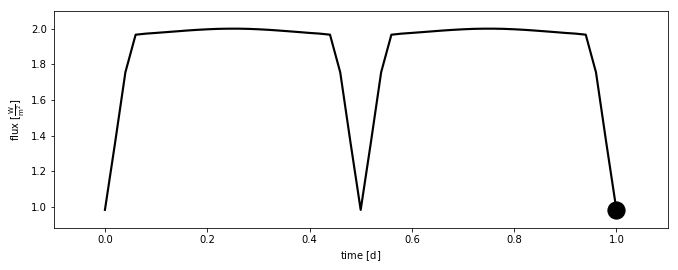

In [13]:
fig = plt.figure(figsize=(11,4))
b['lc01@model'].plot(axpos=111)


b.savefig('animation_binary_complete.gif', fig=fig, tight_layouot=True, draw_sidebars=False, animate=True, save_kwargs={'writer': 'imagemagick'})
plt.show()

Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.3, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.3, zlabel=w, ec=black, label=secondary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.4, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.4, zlabel=w, ec=black, label=se

Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.42, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.42, zlabel=w, ec=black, label=secondary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.46, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.46, zlabel=w, ec=black, labe

Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.66, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.66, zlabel=w, ec=black, label=secondary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.82, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.82, zlabel=w, ec=black, labe

Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.88, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=0.88, zlabel=w, ec=black, label=secondary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=1.0, zlabel=w, ec=black, label=primary@mesh01, y=<data ((1738, 3))>, fc=white, save_kwargs={'writer': 'imagemagick'}, itol=1e-06, ylabel=v, marker=none, x=<data ((1738, 3))>, z=<data ((1738, 3))>, xlabel=u)
Tue, 29 Oct 2019 15:39 PARAMETERS   INFO    calling autofig.mesh(equal_aspect=True, i=1.0, zlabel=w, ec=black, label=

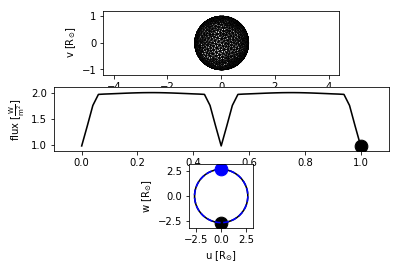

In [14]:
afig, mplanim = b.plot(y={'orb': 'ws'}, 
                       animate=True, save='animations_1.gif', save_kwargs={'writer': 'imagemagick'})